In [2]:
from sklearn.model_selection import *
from sklearn.feature_selection import *
from sklearn.preprocessing import *
from sklearn.metrics import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import NearMiss

!pip install mglearn
import mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 540 kB 5.0 MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582639 sha256=4bf214d67ae420325bb78507a373bc94fee14abbed18277c258875122c750b74
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn


# Dataset Preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

bankruptcy = '/content/drive/MyDrive/data.csv'

Mounted at /content/drive


In [ ]:
# 데이터로드
df = pd.read_csv(bankruptcy)
df
x=df.drop(['budo'],axis=1)
y=df['budo']
# x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, shuffle=True, stratify=y, random_state=0 )

In [ ]:
print(x.shape)
print(y.shape)

(65533, 103)
(65533,)


In [ ]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(x, y)
x_selected = select.transform(x)

print(x_selected)

[[6.3850e+00 6.3850e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [6.7340e+00 6.7340e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [6.0820e+00 6.0820e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [4.8930e+00 4.8930e+00 9.1800e-01 9.1800e-01 1.1278e+07 1.1278e+07]
 [4.7850e+00 4.7850e+00 1.9370e+00 1.9370e+00 5.5741e+07 5.5741e+07]
 [4.7740e+00 4.7740e+00 1.5070e+00 1.5070e+00 3.4675e+07 3.4675e+07]]


# UnderSampling

In [ ]:
from imblearn.under_sampling import NearMiss
# 2 는 모든 소수 클래스 샘플까지의 평균 거리 활용

NM_model = NearMiss(version = 2)
x_selected = pd.DataFrame(x_selected)

x_u, y_u = NM_model.fit_resample(x_selected, y)
x_u = pd.DataFrame(x_u, columns = x_selected.columns)
y_u = pd.Series(y_u)
x_train, x_test, y_train, y_test = train_test_split(x_u,y_u, test_size=0.3, shuffle=True, stratify=y_u, random_state=0 )

print(x_u.shape)
print(y_u.shape)

(7494, 6)
(7494,)


# 1.스케일링이 반드시 필요한 모델 (SVC)

### Pipeline with Grid Search

### SVC (excluding scaling)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

pipe = Pipeline([("svm", SVC())])
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(x_train, y_train)
print(grid.best_score_)
print(grid.score(x_test, y_test))
print(grid.best_params_)

0.7147759771210677
0.740329035126723
{'svm__C': 1, 'svm__gamma': 0.001}


In [ ]:
from sklearn.metrics import classification_report
from sklearn.svm import SVC
svc = SVC(kernel='rbf', C = 1, gamma=0.001)
svc.fit(x_train, y_train)

pred = svc.predict(x_test)

In [ ]:
# c : 1, gamma : 0.001에서 최적의 결과값을 보임
# 테스트셋에 과소 적합을 보임
# Assessment 결과 정밀도는 높으나 재현율은 떨어짐

f1_svc = f1_score(y_test, pred)
recall_svc = recall_score(y_test, pred)
pre_svc = precision_score(y_test, pred)
accu_svc = accuracy_score(y_test, pred)
print("f1 score : {:.3f}".format(f1_svc))
print("recall score : {:.3f}".format(recall_svc))
print("precision score : {:.3f}".format(pre_svc))
print("accuracy score : {:.3f}".format(accu_svc))

f1 score : 0.656
recall score : 0.496
precision score : 0.969
accuracy score : 0.740


### SVC (including MinMax Scaler)

In [ ]:
pipe = Pipeline([("sclaer", MinMaxScaler()), ("svm", SVC())])
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(x_train, y_train)
print(grid.best_score_)
print(grid.score(x_test, y_test))
print(grid.best_params_)

0.9203050524308866
0.9226322810137839
{'svm__C': 1, 'svm__gamma': 100}


In [ ]:
pred = grid.predict(x_test)

f1_mms = f1_score(y_test, pred)
recall_mms = recall_score(y_test, pred)
pre_mms = precision_score(y_test, pred)
accu_mms = accuracy_score(y_test, pred)
print("f1 score : {:.3f}".format(f1_mms))
print("recall score : {:.3f}".format(recall_mms))
print("precision score : {:.3f}".format(pre_mms))
print("accuracy score : {:.3f}".format(accu_mms))

f1 score : 0.918
recall score : 0.867
precision score : 0.976
accuracy score : 0.923


In [ ]:
scaler = MinMaxScaler().fit(x_train, x_test)
x_train_mms = scaler.transform(x_train)

x_train_mms = pd.DataFrame(x_train_mms).to_numpy()

### SVC (including Standard Scaler)

In [ ]:
# 데이터셋 확인

print(x_train.shape)
print(x_test.shape)

print(5245+2249)

(5245, 6)
(2249, 6)
7494


In [ ]:
from sklearn.preprocessing import *

pipe = Pipeline([("sclaer", StandardScaler()), ("svm", SVC())])
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(x_train, y_train)
print(grid.best_score_)
print(grid.score(x_test, y_test))
print(grid.best_params_)

0.9206863679694948
0.9235215651400622
{'svm__C': 1, 'svm__gamma': 1}


In [ ]:
pred = grid.predict(x_test)

f1_std= f1_score(y_test, pred)
recall_std = recall_score(y_test, pred)
pre_std = precision_score(y_test, pred)
accu_std = accuracy_score(y_test, pred)
print("f1 score : {:.3f}".format(f1_std))
print("recall score : {:.3f}".format(recall_std))
print("precision score : {:.3f}".format(pre_std))
print("accuracy score : {:.3f}".format(accu_std))

f1 score : 0.918
recall score : 0.858
precision score : 0.988
accuracy score : 0.924


In [ ]:
scaler = StandardScaler().fit(x_train, x_test)
x_train_std = scaler.transform(x_train)

x_train_std = pd.DataFrame(x_train_std).to_numpy()

### SVC (including Robust Scaler)

In [ ]:
# 데이터셋 확인

print(x_train.shape)
print(x_test.shape)

print(5245+2249)

(5245, 6)
(2249, 6)
7494


In [ ]:
from sklearn.preprocessing import *

pipe = Pipeline([("sclaer", RobustScaler()), ("svm", SVC())])
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(x_train, y_train)
print(grid.best_score_)
print(grid.score(x_test, y_test))
print(grid.best_params_)

0.9096282173498571
0.915073365940418
{'svm__C': 10, 'svm__gamma': 0.1}


In [ ]:
pred = grid.predict(x_test)

f1_rbs = f1_score(y_test, pred)
recall_rbs = recall_score(y_test, pred)
pre_rbs = precision_score(y_test, pred)
accu_rbs = accuracy_score(y_test, pred)
print("f1 score : {:.3f}".format(f1_rbs))
print("recall score : {:.3f}".format(recall_rbs))
print("precision score : {:.3f}".format(pre_rbs))
print("accuracy score : {:.3f}".format(accu_rbs))

f1 score : 0.908
recall score : 0.841
precision score : 0.987
accuracy score : 0.915


In [ ]:
scaler = RobustScaler().fit(x_train, x_test)
x_train_rbs = scaler.transform(x_train)

x_train_rbs = pd.DataFrame(x_train_rbs).to_numpy()

### SVC (including Normalize)

In [ ]:
# 데이터셋 확인

print(x_train.shape)
print(x_test.shape)

print(5245+2249)

(5245, 6)
(2249, 6)
7494


In [ ]:
from sklearn.preprocessing import *

pipe = Pipeline([("sclaer", Normalizer()), ("svm", SVC())])
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(x_train, y_train)
print(grid.best_score_)
print(grid.score(x_test, y_test))
print(grid.best_params_)

0.6840800762631079
0.6927523343708315
{'svm__C': 100, 'svm__gamma': 100}


In [ ]:
pred = grid.predict(x_test)

f1_nor = f1_score(y_test, pred)
recall_nor = recall_score(y_test, pred)
pre_nor = precision_score(y_test, pred)
accu_nor = accuracy_score(y_test, pred)
print("f1 score : {:.3f}".format(f1_nor))
print("recall score : {:.3f}".format(recall_nor))
print("precision score : {:.3f}".format(pre_nor))
print("accuracy score : {:.3f}".format(accu_nor))

f1 score : 0.698
recall score : 0.712
precision score : 0.686
accuracy score : 0.693


In [ ]:
scaler = Normalizer().fit(x_train, x_test)
x_train_nor = scaler.transform(x_train)

x_train_nor = pd.DataFrame(x_train_nor).to_numpy()

# Logistic Regression

In [4]:
# 데이터로드
df = pd.read_csv(bankruptcy)
df
x=df.drop(['budo'],axis=1)
y=df['budo']
# x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, shuffle=True, stratify=y, random_state=0 )

In [5]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(x, y)
x_selected = select.transform(x)

In [6]:
from imblearn.under_sampling import NearMiss
# 2 는 모든 소수 클래스 샘플까지의 평균 거리 활용

NM_model = NearMiss(version = 2)
x_selected = pd.DataFrame(x_selected)

x_u, y_u = NM_model.fit_resample(x_selected, y)
x_u = pd.DataFrame(x_u, columns = x_selected.columns)
y_u = pd.Series(y_u)
x_train, x_test, y_train, y_test = train_test_split(x_u,y_u, test_size=0.3, shuffle=True, stratify=y_u, random_state=0 )

print(x_u.shape)
print(y_u.shape)

(7494, 6)
(7494,)


## 스케일링 없이

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train, y_train)

pred = lr.predict(x_test)

In [ ]:
f1_lr = f1_score(y_test, pred)
recall_lr = recall_score(y_test, pred)
pre_lr = precision_score(y_test, pred)
accu_lr = accuracy_score(y_test, pred)
print("f1 score : {:.3f}".format(f1_lr))
print("recall score : {:.3f}".format(recall_lr))
print("precision score : {:.3f}".format(pre_lr))
print("accuracy score : {:.3f}".format(accu_lr))

f1 score : 0.161
recall score : 0.088
precision score : 0.943
accuracy score : 0.542


## MinMax Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_mms = scaler.transform(x_train)
x_test_mms = scaler.transform(x_test)


In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train_mms, y_train)

pred = lr.predict(x_test_mms)

In [ ]:
f1_mms_lr = f1_score(y_test, pred)
recall_mms_lr = recall_score(y_test, pred)
pre_mms_lr = precision_score(y_test, pred)
accu_mms_lr = accuracy_score(y_test, pred)
print("f1 score : {:.3f}".format(f1_mms_lr))
print("recall score : {:.3f}".format(recall_mms_lr))
print("precision score : {:.3f}".format(pre_mms_lr))
print("accuracy score : {:.3f}".format(accu_mms_lr))

f1 score : 0.903
recall score : 0.839
precision score : 0.977
accuracy score : 0.910


## Standard

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train_st, y_train)

pred = lr.predict(x_test_st)

In [ ]:
f1_st_lr = f1_score(y_test, pred)
recall_st_lr = recall_score(y_test, pred)
pre_st_lr = precision_score(y_test, pred)
accu_st_lr = accuracy_score(y_test, pred)
print("f1 score : {:.3f}".format(f1_st_lr))
print("recall score : {:.3f}".format(recall_st_lr))
print("precision score : {:.3f}".format(pre_st_lr))
print("accuracy score : {:.3f}".format(accu_st_lr))

f1 score : 0.903
recall score : 0.840
precision score : 0.976
accuracy score : 0.910


## Robust

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(x_train)
x_train_rb = scaler.transform(x_train)
x_test_rb = scaler.transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train_rb, y_train)

pred = lr.predict(x_test_rb)

In [ ]:
f1_rb_lr = f1_score(y_test, pred)
recall_rb_lr = recall_score(y_test, pred)
pre_rb_lr = precision_score(y_test, pred)
accu_rb_lr = accuracy_score(y_test, pred)
print("f1 score : {:.3f}".format(f1_rb_lr))
print("recall score : {:.3f}".format(recall_rb_lr))
print("precision score : {:.3f}".format(pre_rb_lr))
print("accuracy score : {:.3f}".format(accu_rb_lr))

f1 score : 0.902
recall score : 0.839
precision score : 0.974
accuracy score : 0.908


## Normailzer

In [7]:
from sklearn.preprocessing import Normalizer

scaler = Normalizer()
scaler.fit(x_train)
x_train_N = scaler.transform(x_train)
x_test_N = scaler.transform(x_test)


In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train_N, y_train)

pred = lr.predict(x_test_N)

In [9]:
f1_N_lr = f1_score(y_test, pred)
recall_N_lr = recall_score(y_test, pred)
pre_N_lr = precision_score(y_test, pred)
accu_N_lr = accuracy_score(y_test, pred)
print("f1 score : {:.3f}".format(f1_N_lr))
print("recall score : {:.3f}".format(recall_N_lr))
print("precision score : {:.3f}".format(pre_N_lr))
print("accuracy score : {:.3f}".format(accu_N_lr))

f1 score : 0.316
recall score : 0.194
precision score : 0.848
accuracy score : 0.580


## 3. Scaler 별 x_data 시각화

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

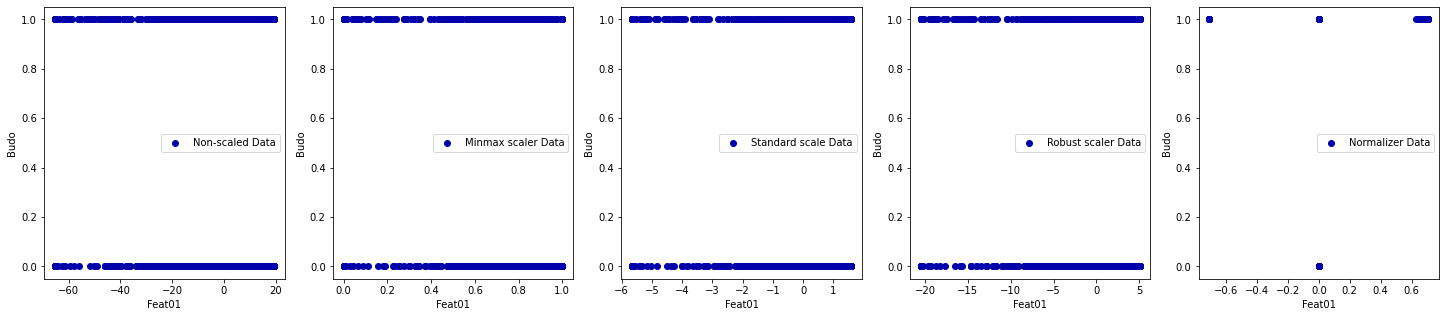

In [ ]:
# subplots는 축의 scale 조정이 안되네.... 그래서 밑에 일일이 다시 그려봄

x_u = pd.DataFrame(x_u).to_numpy()

fig, axes = plt.subplots(1,5, figsize=(25,5))
axes[0].scatter(x_u[:,0], y_u, c=mglearn.cm2(0), label="Non-scaled Data")
axes[0].legend(loc="best")

axes[1].scatter(x_train_mms[:,0], y_train, c=mglearn.cm2(0), label="Minmax scaler Data")
axes[1].legend(loc="best")

axes[2].scatter(x_train_std[:,0], y_train, c=mglearn.cm2(0), label="Standard scale Data")
axes[2].legend(loc="best")

axes[3].scatter(x_train_rbs[:,0], y_train, c=mglearn.cm2(0), label="Robust scaler Data")
axes[3].legend(loc="best")

axes[4].scatter(x_train_nor[:,0], y_train, c=mglearn.cm2(0), label="Normalizer Data")
axes[4].legend(loc="best")

for ax in axes :
    ax.set_xlabel("Feat01")
    ax.set_ylabel("Budo")

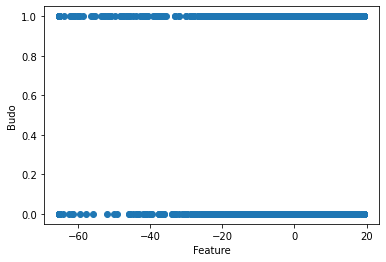

In [ ]:
# Non-scaled

import numpy as np
import matplotlib.pyplot as plt

plt.scatter(x_u[:,0], y_u)
plt.xlabel("Feature")
plt.ylabel("Budo")
plt.show()

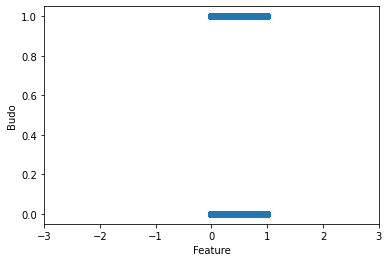

In [ ]:
# MinMax

plt.scatter(x_train_mms[:,0], y_train)
plt.xlabel("Feature")
plt.ylabel("Budo")
plt.xlim((-3,3))
plt.show()

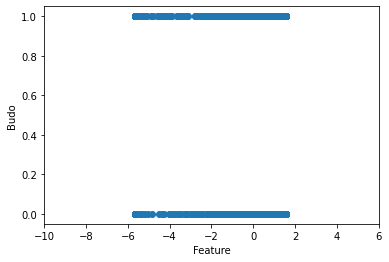

In [ ]:
# Standard....-2가 첨도가 가장 높은 위치라고 보면 되겠군...

plt.scatter(x_train_std[:,0], y_train)
plt.xlabel("Feature")
plt.ylabel("Budo")
plt.xlim((-10,6))
plt.show()

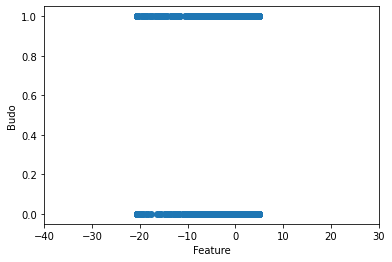

In [ ]:
# Robust....는 scaling 원리를 내가 모름 ~~

plt.scatter(x_train_rbs[:,0], y_train)
plt.xlabel("Feature")
plt.ylabel("Budo")
plt.xlim((-40,30))
plt.show()

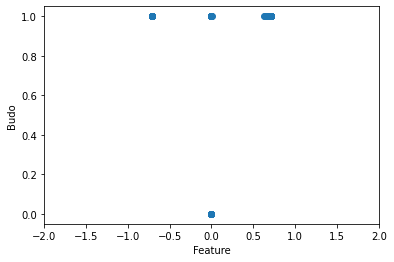

In [ ]:
# Normalize

plt.scatter(x_train_nor[:,0], y_train)
plt.xlabel("Feature")
plt.ylabel("Budo")
plt.xlim((-2,2))
plt.show()

# Summary


In [ ]:
print("--------------Non-scaled--------------")
print("f1 score : {:.3f}".format(f1_svc))
print("recall score : {:.3f}".format(recall_svc))
print("precision score : {:.3f}".format(pre_svc))
print("accuracy score : {:.3f}".format(accu_svc))
print()
print("--------------MinMaxScaler--------------")
print("f1 score : {:.3f}".format(f1_mms))
print("recall score : {:.3f}".format(recall_mms))
print("precision score : {:.3f}".format(pre_mms))
print("accuracy score : {:.3f}".format(accu_mms))
print()
print("--------------StandardScaler--------------")
print("f1 score : {:.3f}".format(f1_std))
print("recall score : {:.3f}".format(recall_std))
print("precision score : {:.3f}".format(pre_std))
print("accuracy score : {:.3f}".format(accu_std))
print()
print("--------------RobustScaler--------------")
print("f1 score : {:.3f}".format(f1_rbs))
print("recall score : {:.3f}".format(recall_rbs))
print("precision score : {:.3f}".format(pre_rbs))
print("accuracy score : {:.3f}".format(accu_rbs))
print()
print("--------------Normalizer--------------")
print("f1 score : {:.3f}".format(f1_nor))
print("recall score : {:.3f}".format(recall_nor))
print("precision score : {:.3f}".format(pre_nor))
print("accuracy score : {:.3f}".format(accu_nor))

--------------Non-scaled--------------
f1 score : 0.656
recall score : 0.496
precision score : 0.969
accuracy score : 0.740

--------------MinMaxScaler--------------
f1 score : 0.918
recall score : 0.867
precision score : 0.976
accuracy score : 0.923

--------------StandardScaler--------------
f1 score : 0.918
recall score : 0.858
precision score : 0.988
accuracy score : 0.924

--------------RobustScaler--------------
f1 score : 0.908
recall score : 0.841
precision score : 0.987
accuracy score : 0.915

--------------Normalizer--------------
f1 score : 0.698
recall score : 0.712
precision score : 0.686
accuracy score : 0.693
